# Compute Cluster Power Spectrum, $P(k)$ with Nbodykit

Here I try to run `nbodykit` to compute the cluster power spectrum. 

Following this notebook:\
https://nbodykit.readthedocs.io/en/latest/cookbook/convpower.html \
https://github.com/bccp/nbodykit-cookbook/blob/master/recipes/fftpower.ipynb

## Installing Nobdykit

If you don't have the package it might take some time to install it. In the NERSC computer I had to create a special environement for nbodykit.

```
conda create --name nbodykit-env python=3.7 # or use python=2 for python 2.7*
source activate nbodykit-env
conda install -c bccp nbodykit
```

Then, to add to your jupyter notebook environement.
```
pip install ipykernel
python -m ipykernel install --user --name=nbodykit-env
```

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# !pip install nbodykit

In [ ]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [4]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

In [5]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [6]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
cosmo0 

FlatLambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

## Loading the Catalog

In [14]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')

print('halo file name: %s'%floc.mock_nbody_fname)
data = FITSCatalog(floc.mock_nbody_fname)

print('Random file name: %s'%floc.mock_random_fname)
randoms = FITSCatalog(floc.mock_random_fname)

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_nbody.fits
Random file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0_randoms.fits


In [13]:
# np.array(data['z']).min()

In [15]:
Nr = int(50*data.csize)
indices = np.random.randint(randoms.csize, size=Nr)
indices.sort()
randoms = randoms[indices]

In [16]:
zbins = np.array([0.2, 0.32, 0.373, 0.51, 0.65])
zmin_list = np.array([0.2, 0.373, 0.51])
zmax_list = np.array([0.32, 0.51, 0.64])
zmeans = np.array([0.25, 0.44, 0.575])

In [17]:
Table(getdata(floc.mock_random_fname))

ra,dec,z
float64,float64,float64
27.494875657585226,-42.14373614603615,0.5794727930047214
24.784201476039073,-9.8813123027411,0.56157774271709
65.16955187508142,-41.01922402225469,0.6410671999594587
71.2603057836634,-25.51083334072242,0.3201134767745129
66.27347617593995,-21.385785808893115,0.3838504333880149
15.502633535892699,-3.57060803060652,0.5760858255353751
32.053675885864266,-11.321410708585459,0.5096356562441018
1.624476026288903,-28.42411007416158,0.40673138425791516
18.379800591081278,4.223659787565598,0.538591233602153


In [22]:
np.array(randoms['z'])

array([-1.66093447e+116, -1.66093447e+116, -1.66093447e+116, ...,
        3.34439101e-230,  3.34439101e-230,  3.34439101e-230])

## Estimating n(z)

A nice paper to understand the importance of the volume element in surveys:
https://arxiv.org/pdf/astro-ph/9304022.pdf

In [19]:
# fiducial cosmology
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.3)

# add Cartesian position column
data['Position'] = transform.SkyToCartesian(data['ra'], data['dec'], data['z'], cosmo=cosmo)
randoms['Position'] = transform.SkyToCartesian(randoms['ra'], randoms['dec'], randoms['z'], cosmo=cosmo)

/global/homes/j/jesteves/.conda/envs/for-nbodykit/lib/python3.10/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/global/homes/j/jesteves/.conda/envs/for-nbodykit/lib/python3.10/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/global/homes/j/jesteves/.conda/envs/for-nbodykit/lib/python3.10/site-packages/nbodykit/algorithms/zhist.py:243: RuntimeWarning: invalid value encountered in subtract
  rsum = comm.allreduce((abs(data - cmean)**2).sum())


Text(0, 0.5, '$n(z)$ $[h^{3} \\mathrm{Mpc}^{-3}]$')

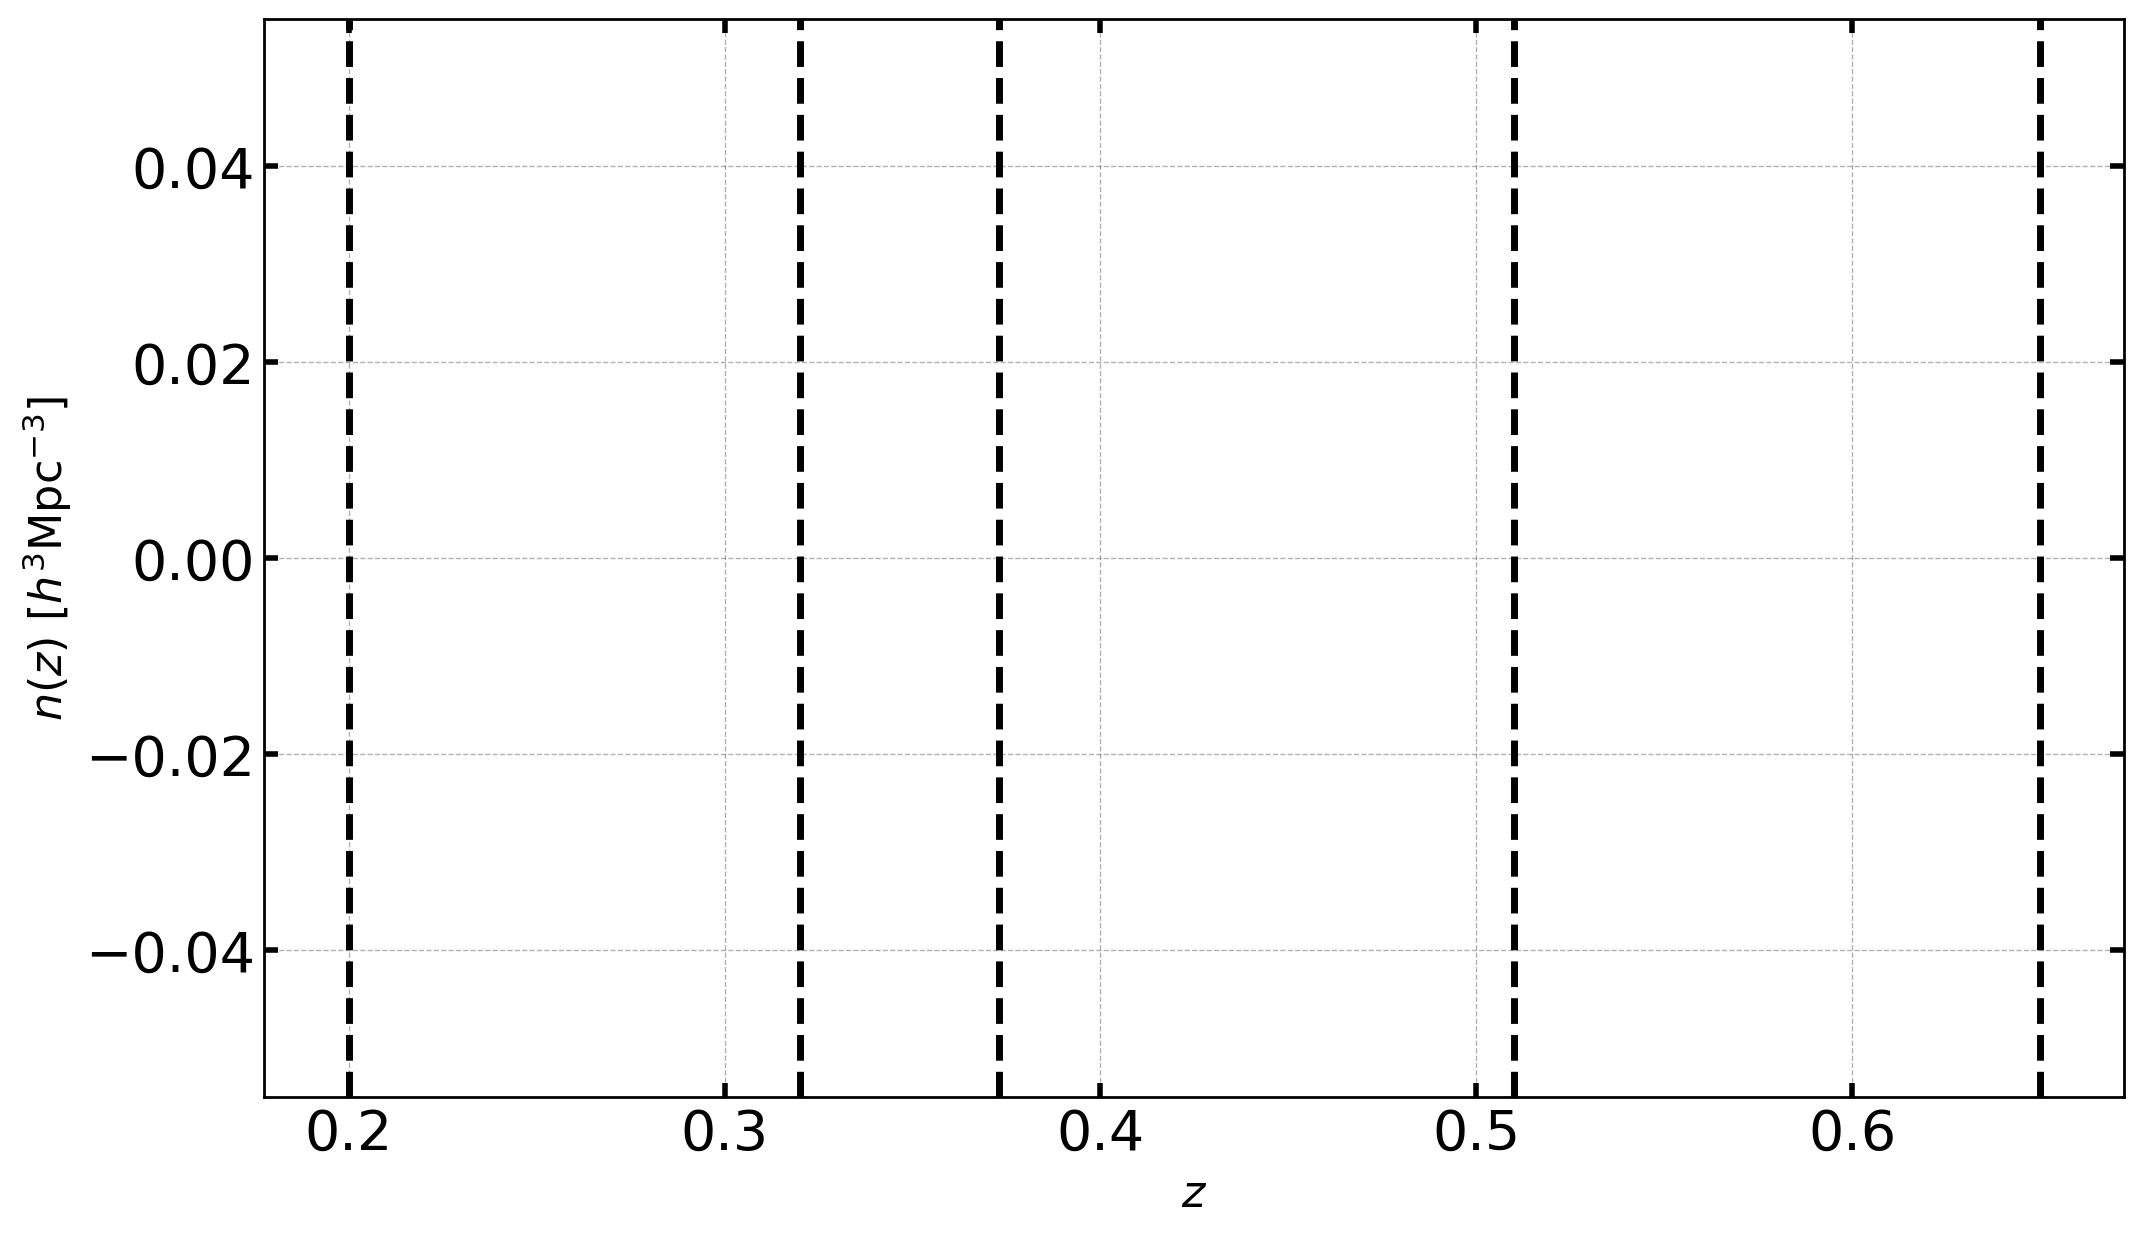

In [20]:
# the sky fraction, used to compute volume in n(z)
FSKY = 1. # a made-up value

# compute n(z) from the randoms
zhist = RedshiftHistogram(randoms, FSKY, cosmo, redshift='z')

# re-normalize to the total size of the data catalog
alpha = 1.0 * data.csize / randoms.csize

# add n(z) from randoms to the FKP source
nofz = InterpolatedUnivariateSpline(zhist.bin_centers, alpha*zhist.nbar)

# plot
plt.plot(zhist.bin_centers, alpha*zhist.nbar)
for zl in zbins:
    plt.axvline(zl,color='k',ls='--')

plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"$n(z)$ $[h^{3} \mathrm{Mpc}^{-3}]$", fontsize=16)

In [ ]:
# add the n(z) columns to the FKPCatalog
randoms['NZ'] = nofz(randoms['z'])
data['NZ'] = nofz(data['z'])

# add the weights
# data['Weight'] = np.ones(data.csize)
# randoms['Weight'] = randoms['weight']

In [ ]:
# plt.hist(np.array(randoms['weight'])[::100])

In [ ]:
# initialize the FKP source
fkp = FKPCatalog(data, randoms)

# print out the columns
print("columns in FKPCatalog = ", fkp.columns)

## Adding FKP Weights

Here, we add a column ``FKPWeight`` that gives the appropriate FKP weight for each catalog. The FKP weights are given by:

$$
w_\mathrm{FKP} = \frac{1}{1 + n(z)P_0}.
$$

Here, we use a value of $P_0 = 2 \times 10^4 \ h^{-3} \mathrm{Mpc}^3$.

I took this value from: https://arxiv.org/pdf/1608.05446.pdf

In [ ]:
fkp['data/FKPWeight'] = 1.0 / (1 + fkp['data/NZ'] * 2e4)
fkp['randoms/FKPWeight'] = 1.0 / (1 + fkp['randoms/NZ'] * 2e4)

In [ ]:
data['FKPWeight'] = 1.0 / (1 + fkp['data/NZ'] * 2e4)
randoms['FKPWeight'] =1.0 / (1 + fkp['randoms/NZ'] * 2e4)

## Compute $P(k)$ Directly with Meshgrid

The main paremeter is `Nmesh` which is the size of the cubic meshigrid density estimator. Another paremeter to pay attention is the window type `tsc`.
https://nbodykit.readthedocs.io/en/latest/mesh/overview.html#What-is-a-MeshSource?

In [210]:
def sel_bin(x, xmin, xmax):
    return 

def redshift_slice(jointCat, zmin, zmax):
    datas = []
    for cat in jointCat:
        mask = (cat['z']>=zmin)&(cat['z']<zmax)
        datas.append(cat[mask].copy())
    return datas,FKPCatalog(*datas)

In [213]:
catalogs = []
datas = []
for zmin, zmax in zip(zmin_list, zmax_list):
    ds, fks = redshift_slice([data, randoms], zmin, zmax)
    catalogs.append(fks)
    datas.append(ds)

In [214]:
catalogs

[FKPCatalog(species=['data', 'randoms']),
 FKPCatalog(species=['data', 'randoms']),
 FKPCatalog(species=['data', 'randoms'])]

In [215]:
data.csize

263624

In [216]:
np.array(catalogs[2]['data']['Position']).shape

(114603, 3)

In [113]:
# start the meshgrid density estimator in the box space of x,y and z
results = []
for i, fkp in enumerate(catalogs):
    print('Redshift bin: %i'%i)
    mesh = fkp.to_mesh(Nmesh=512, nbar='NZ', fkp_weight='FKPWeight', window='sym20')
    # compute the multipoles
    r = ConvolvedFFTPower(mesh, poles=[0,2,4], dk=0.01, kmin=0.005, kmax=2.)
    results.append(r.poles)

Redshift bin: 0


/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


Redshift bin: 1


/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


Redshift bin: 2


/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


In [114]:
for key in r.attrs:
    print("%s = %s" % (key, str(r.attrs[key])))

poles = [0, 2, 4]
dk = 0.01
kmin = 0.005
kmax = 2.0
Nmesh = [512 512 512]
BoxSize = [1851. 2739. 1725.]
BoxPad = [0.02 0.02 0.02]
BoxCenter = [ 722.24856972  206.97422226 -666.6095936 ]
mesh.resampler = sym20
mesh.interlaced = False
alpha = 0.04915172603390694
data.norm = 1.0062858961472538
randoms.norm = 1.006051014877185
shotnoise = 71343.76806831341
data.N = 114603
data.W = 114603.0
data.W2 = 88537.95545283088
data.num_per_cell = 0.000659659172988168
randoms.N = 2331617
randoms.W = 2331617.0
randoms.W2 = 1801494.151034797
randoms.num_per_cell = 0.013422177367171623
data.ext = 1
randoms.ext = 1


In [128]:
# use the same number of mu wedges and number of multipoles
Nmu = Nell = 3
mu_edges = numpy.linspace(0, 1, Nmu+1)

# get a BinnedStatistic holding the P(k,mu) wedges
Pkmu = r.to_pkmu(mu_edges, 4)

In [133]:
Pkmu[:,0]

<BinnedStatistic: dims: (k: 199), variables: ('power', 'k', 'mu')>

In [117]:
# FFTCorr(mesh,mode='1d',rmin=1., rmax=210.)

### Measurements Results

#### Rolling Average

The bin size is a parameter that cannot be set to be logarithmic. For this reason i choose a ver low parameter in order to probe the large scales. However, our result is noisy due to the algorithm flutuations of the meshigrid density estimation. To have a better estimaton of the mean value I use two rolling averages for two different scales.

In [129]:
from scipy.ndimage import uniform_filter1d

kvec = np.logspace(-3, np.log10(5.), 50)

def roll_average(poles, k_break=0.22, Nl=20, Nu=10, kmin=0.005, kmax=1.3):
    poles = poles.sel(k=slice(kmin, kmax),method='nearest')
    
    P = poles['power_0'].real - poles.attrs['shotnoise']
    isnan = np.isnan(np.log(P))
    k, pk = poles['k'][~isnan], P[~isnan]
    log_k, log_pk = np.log(k), np.log(pk)

    # rolling average
    y = uniform_filter1d(pk, size=int(k.size/Nl)+1)
    y2 = uniform_filter1d(pk, size=int(k.size/Nu)+1)
    ix = np.where(k>0.22)[0]
    y[ix] = y2[ix]
    return k, pk, y


In [130]:
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis

colors = Plasma[5]

In [131]:
zlabel = [r'$ %.2f < z < %.2f$'%(zmin,zmax) for zmin, zmax in zip(zmin_list, zmax_list)]

Text(0.5, 1.0, 'Buzzar Mock - Cluster P(k)')

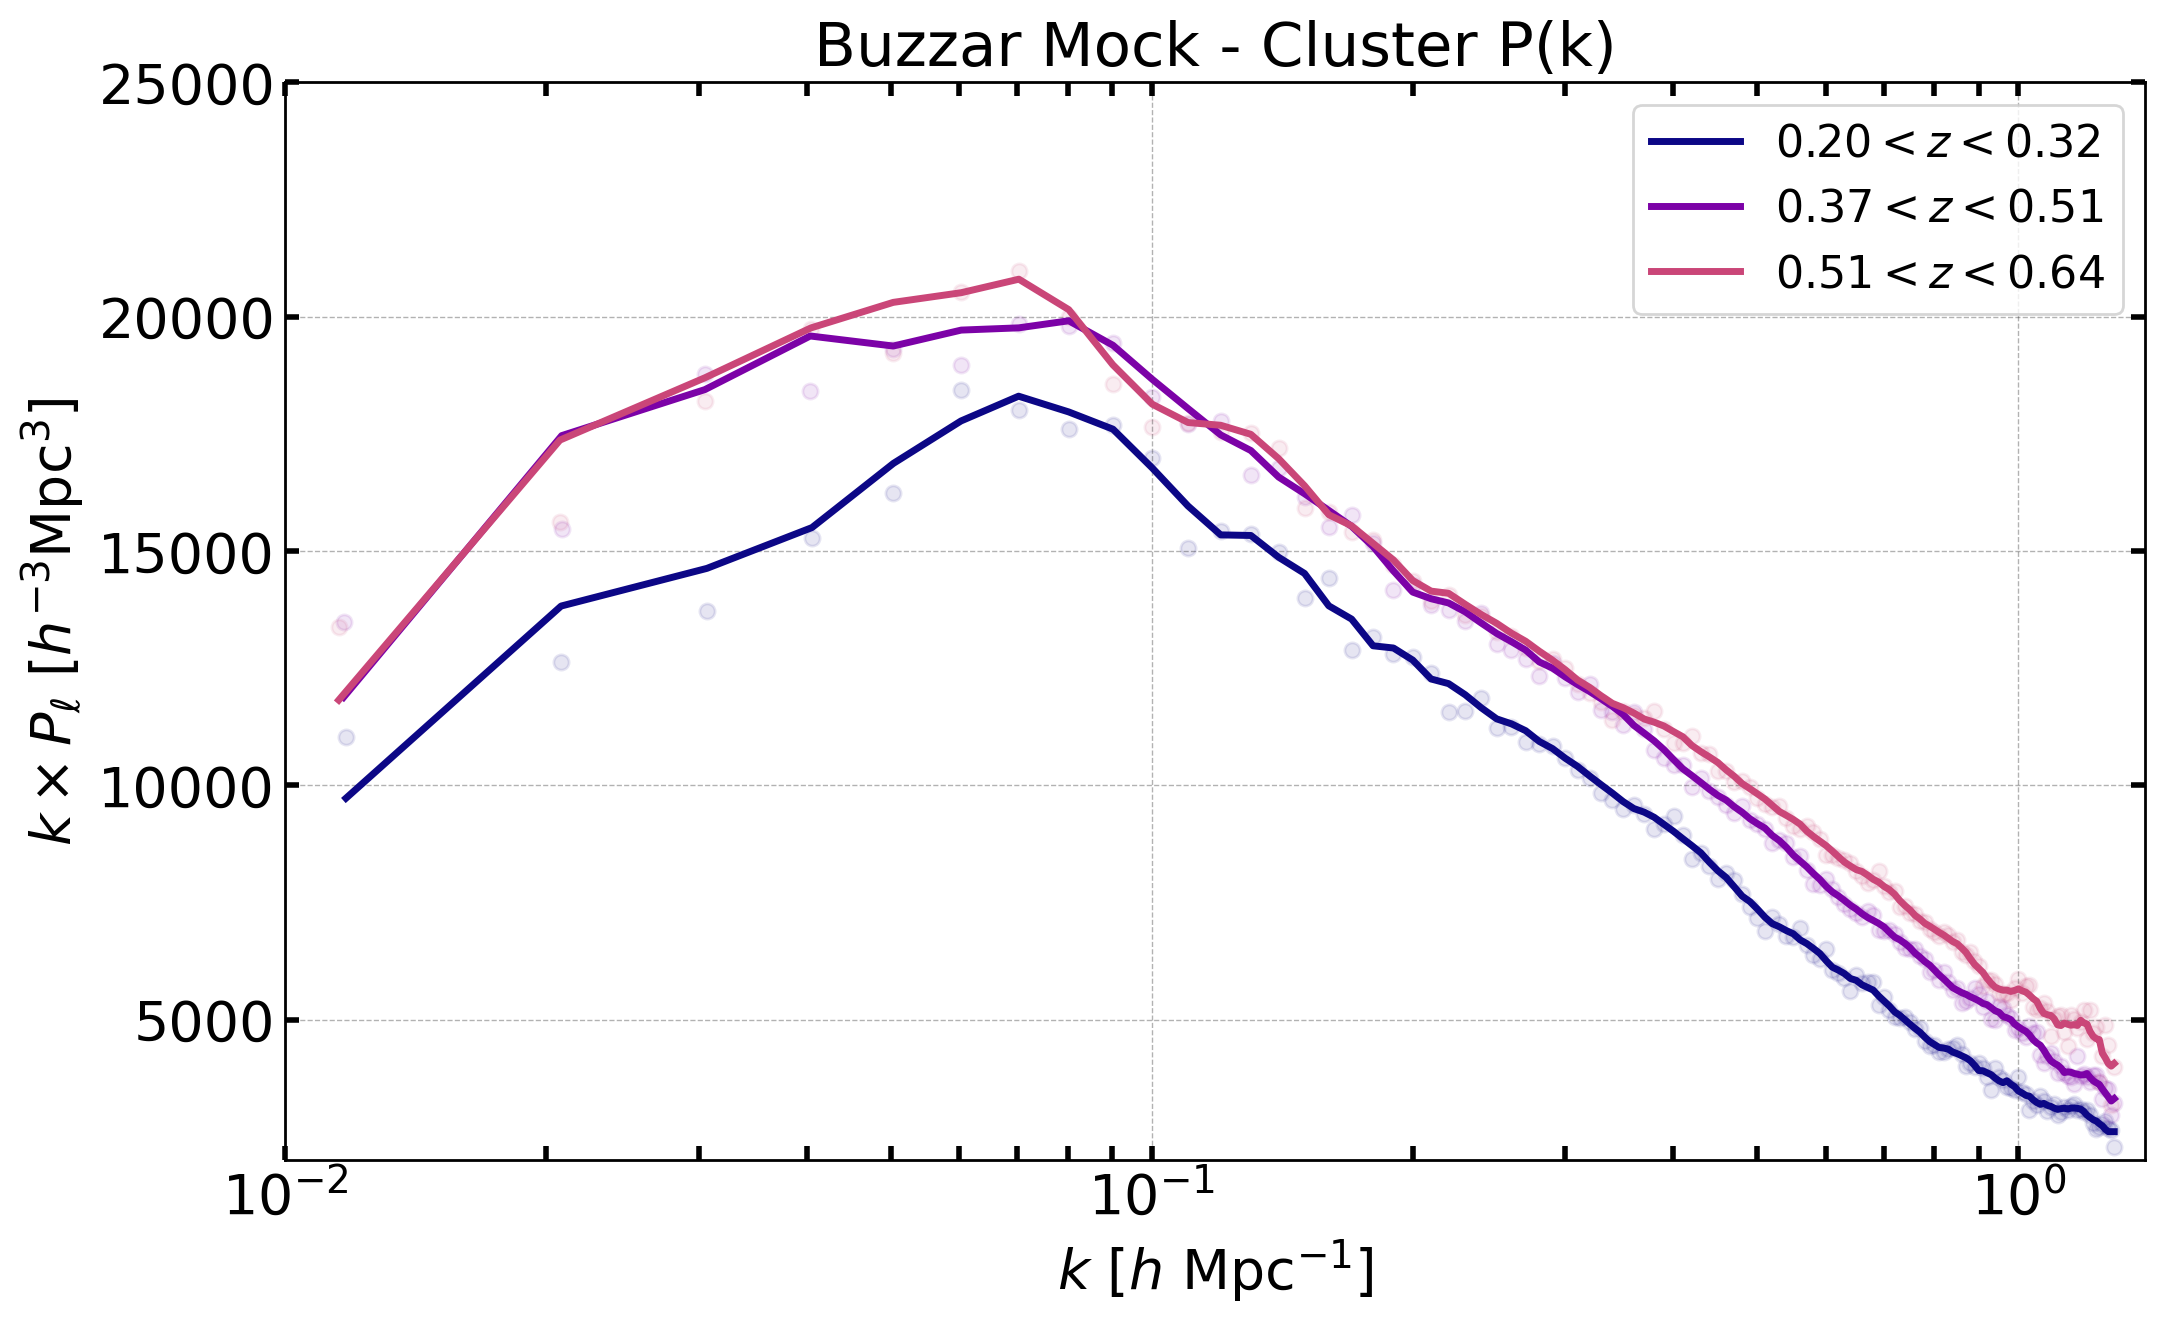

In [147]:
# plt.loglog()
plt.xscale('log')
avg_pks = []
for i in range(3):
    k, pk, pk_avg = roll_average(results[i], k_break=0.01, Nl=60, Nu=20)
    plt.scatter(k, k*pk, color=colors[i], alpha=0.1, s=30)
    plt.plot(k, k*pk_avg, '-', color=colors[i], label=zlabel[i])
    avg_pks.append([k, pk])

plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$k \times P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.01, 1.4)
plt.ylim(2e3, 2.5e4)
plt.title('Buzzar Mock - Cluster P(k)')

In [148]:
from scipy.interpolate import interp1d
def interpolate_pk(k, pk):
    log_k, log_pk = np.log(k), np.log(pk)
    pk_interp = interp1d(log_k, log_pk, bounds_error=False, kind='cubic')
    pk_vec = np.exp(pk_interp(np.log(kvec)))
    return pk_vec

In [149]:
import hankl
print("Using hankel v{}".format(hankl.__version__))

def get_corrFunc(k, pk):
    pk_vec = interpolate_pk(k, pk)
    is_nan = np.isnan(pk_vec)
    s, xi0 = hankl.P2xi(kvec[~is_nan], pk_vec[~is_nan], l=0)
    return s, xi0

Using hankel v1.1.0


In [150]:
corrFuncs = []
for i in range(3):
    k, pk = avg_pks[i]
    s, crf = get_corrFunc(k, pk)
    corrFuncs.append([s, crf])

In [232]:
cr.attrs

{'Nmesh': array([512, 512, 512]),
 'BoxSize': array([1851., 2739., 1725.]),
 'Lx': 1851.0,
 'Ly': 2739.0,
 'Lz': 1725.0,
 'volume': 8745558525.0,
 'mode': '1d',
 'los': [0, 0, 1],
 'Nmu': 1,
 'poles': [0],
 'dr': 3.369140625,
 'rmin': 1.0,
 'rmax': 210.0,
 'N1': 114603,
 'N2': 114603,
 'shotnoise': 76324.21874934062}

In [242]:
dd = FFTCorr(datas[0][0], '1d', Nmesh=512, BoxSize=np.array([1851., 2739., 1725.]), rmin=3., rmax=200., poles=[0])


In [243]:
rr = FFTCorr(datas[0][1], '1d', Nmesh=512, BoxSize=np.array([1851., 2739., 1725.]), rmin=3., rmax=200., poles=[0])

In [244]:
dr = FFTCorr(datas[0][0], '1d', second=datas[0][1], Nmesh=512, BoxSize=np.array([1851., 2739., 1725.]), rmin=3., rmax=200., poles=[0])

array([1851., 2739., 1725.])

In [275]:
# from nbodykit.algorithms.paircount_tpcf.tpcf import BasePairCount2PCF

# b2pc = SimulationBox2PCF('1d', datas[0][0], radii, randoms1=datas[0][1], periodic=False, BoxSize=mesh.attrs['BoxSize'])

In [ ]:
b2pc.attrs

In [329]:
def ls_estimator(dd, rr, dr):
    xdd = dd.poles['corr_0'].real
    xrr = rr.poles['corr_0'].real
    xdr = dr.poles['corr_0'].real
    return (xdd-2*xdr+xrr)/xrr

In [330]:
dd.poles

<BinnedStatistic: dims: (r: 58), variables: ('r', 'corr_0', 'modes')>

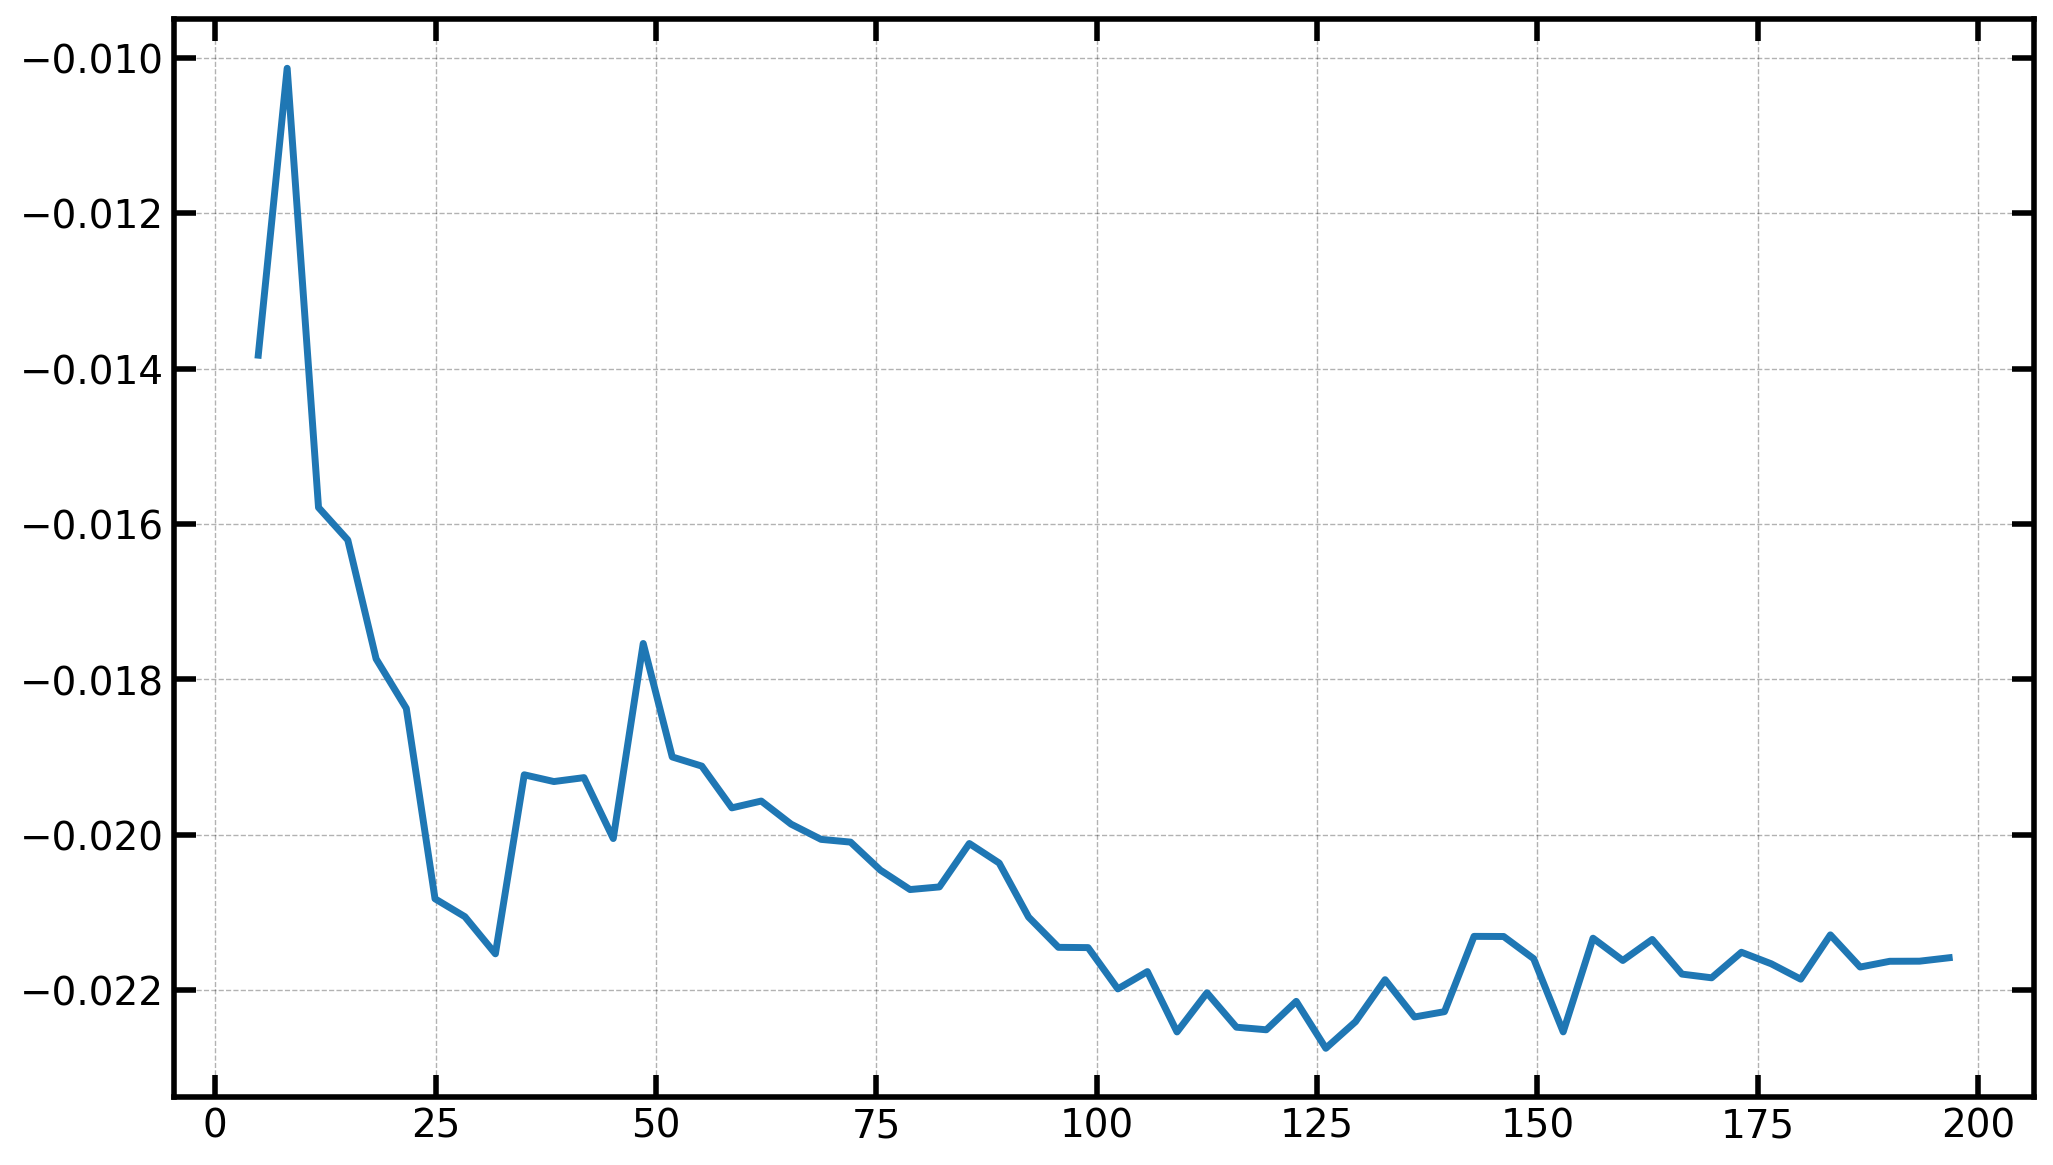

In [331]:
# plt.plot(dd.poles['r'], dd.poles['r']*dd.poles['r']*(dd.poles['corr_0']))
# plt.plot(rr.poles['r'], rr.poles['r']*rr.poles['r']*(rr.poles['corr_0']))
# plt.plot(dr.poles['r'], dr.poles['r']*dr.poles['r']*(dr.poles['corr_0']))
plt.plot(dr.poles['r'], ls_estimator(dr, rr, dr))

In [332]:
# cr = SurveyData2PCF('1d', datas[2][0], datas[2][1], radii, cosmo=cosmo, ra='ra', dec='dec', redshift='z', show_progress=True)


In [333]:
# help(FFTCorr)

In [334]:
# cr = FFTCorr(mesh, mode='1d', poles=[0],rmin=1., rmax=210.)
# radii = np.logspace(np.log10(3.), np.log10(200), 20)
# cr = SurveyData2PCF('1d', datas[2][0], datas[2][0], radii, cosmo=cosmo,  ra='ra', dec='dec', redshift='z')

In [335]:
# help(SurveyData2PCF)

In [336]:
r.poles

<BinnedStatistic: dims: (k: 199), variables: 5 total>

In [337]:
cr.poles

<BinnedStatistic: dims: (r: 62), variables: ('r', 'corr_0', 'modes')>

In [338]:
cr.poles.attrs['shotnoise']

76324.21874934062

/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


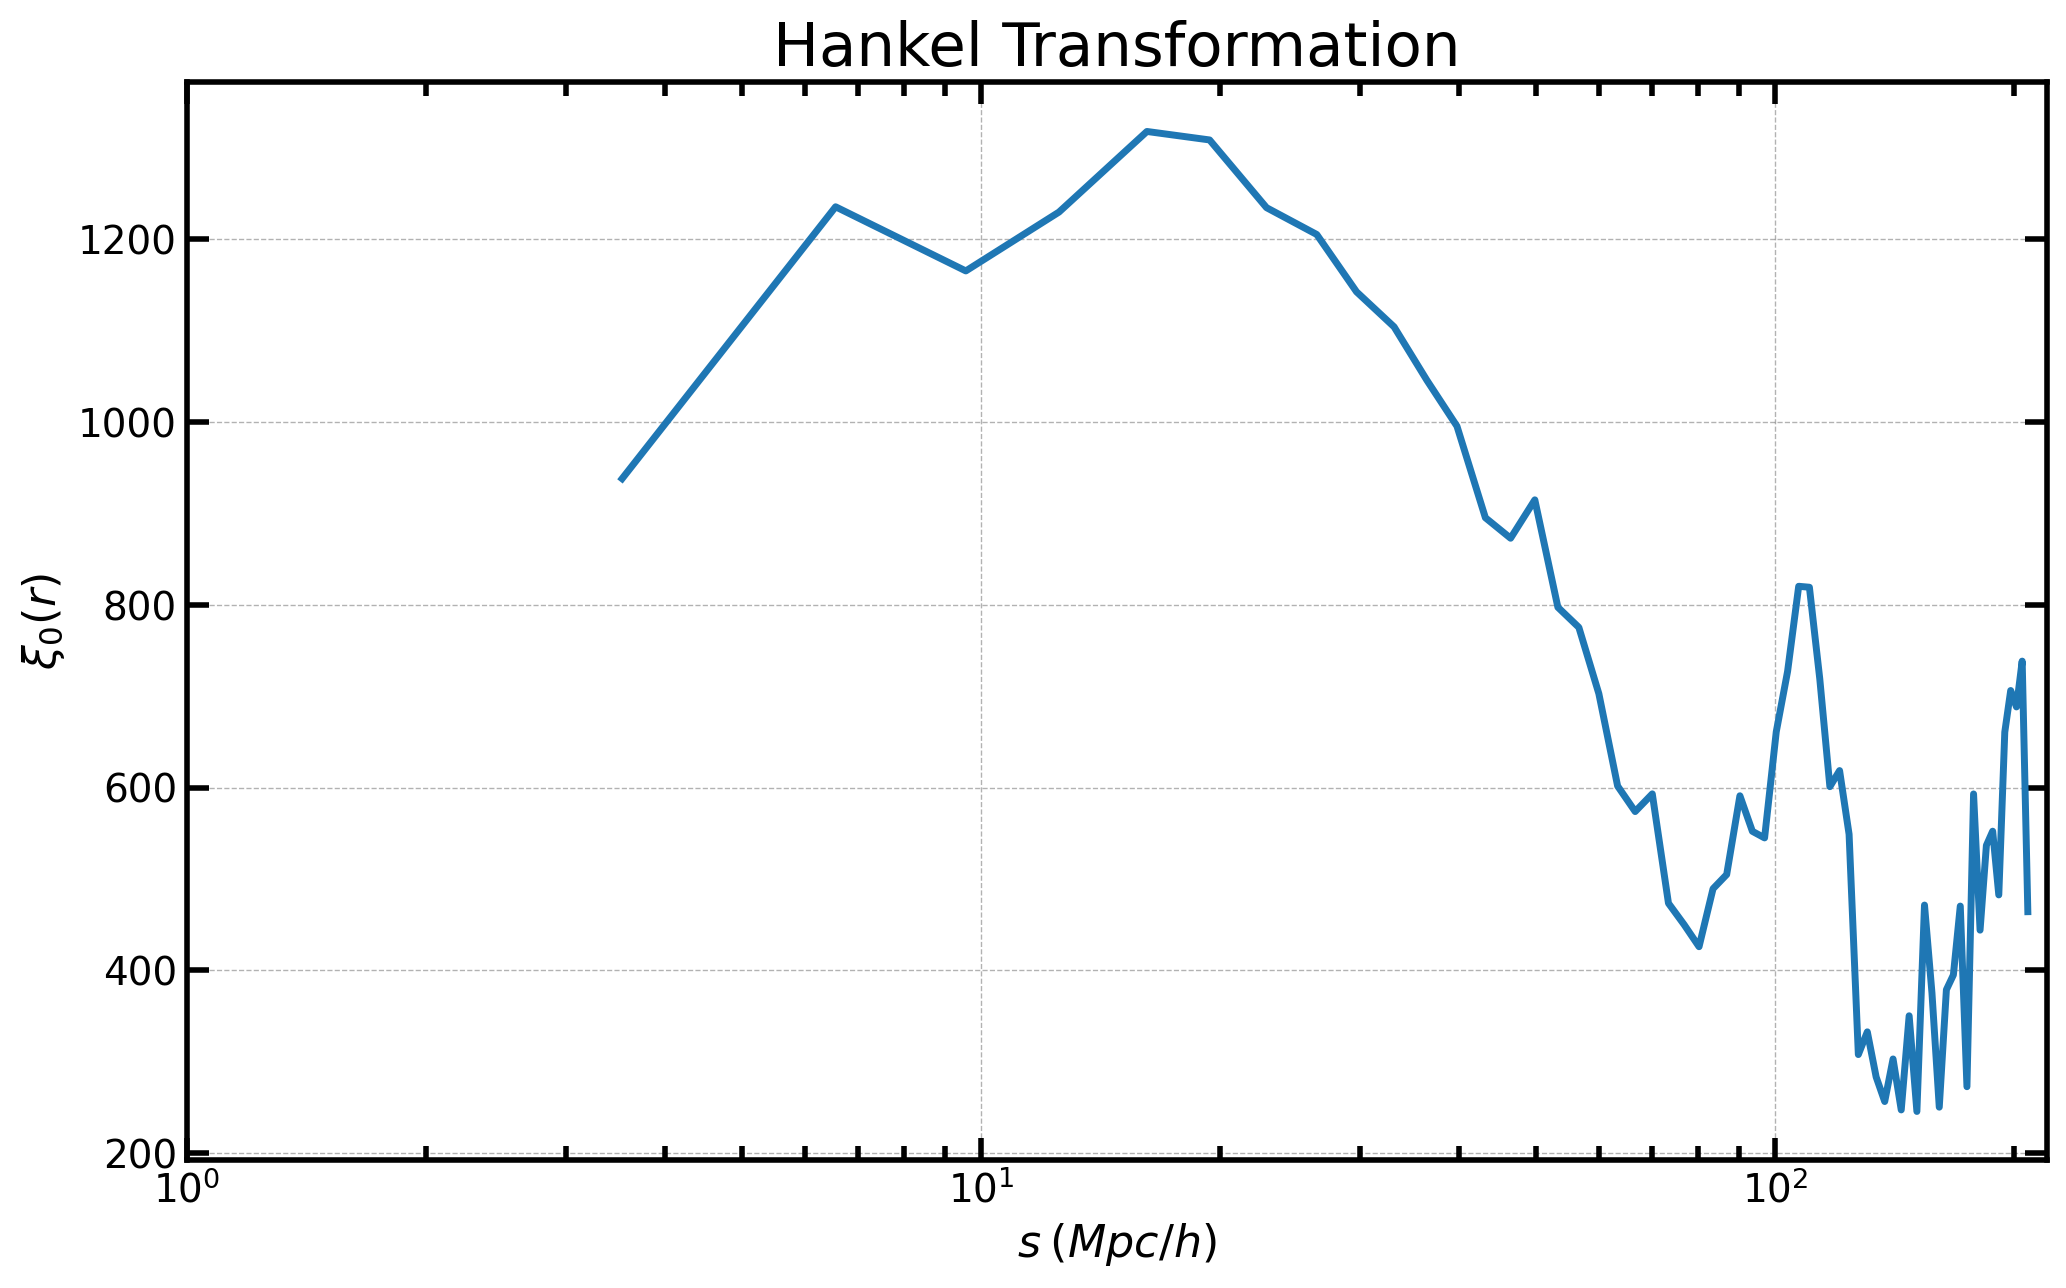

In [339]:
plt.xscale('log')
# plt.loglog()
# for i in range(3):
#     s, xi0 = corrFuncs[i]
#     plt.plot(s, xi0, color=colors[i])

plt.plot(cr.poles['r'], cr.poles['r']*cr.poles['r']*(1e10*cr.poles['corr_0']))
# plt.ylim(-60,30)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$\xi_{0}(r)$')
# plt.legend()
plt.title('Hankel Transformation')
plt.xlim(1.,220)
plt.subplots_adjust(wspace=0.25)
# fig.tight_layout()
# plt.savefig('pk_mock_lgt5.png', transparent=False, facecolor='w', dpi=150)

In [340]:
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at /global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/camb


In [341]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=70, ombh2=0.046*0.7**2, omch2=0.286*0.7**2)
pars.InitPower.set_params(ns=0.96)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=list(zmeans), kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints = 1000)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints = 1000)


Note: redshifts have been re-sorted (earliest first)


[ 004930.41 ]   0: 11-24 00:29  root            WARNING  get_matter_power_spectrum using larger k_max than input parameter Transfer.kmax
[ 004933.07 ]   0: 11-24 00:29  root            WARNING  get_matter_power_spectrum using larger k_max than input parameter Transfer.kmax


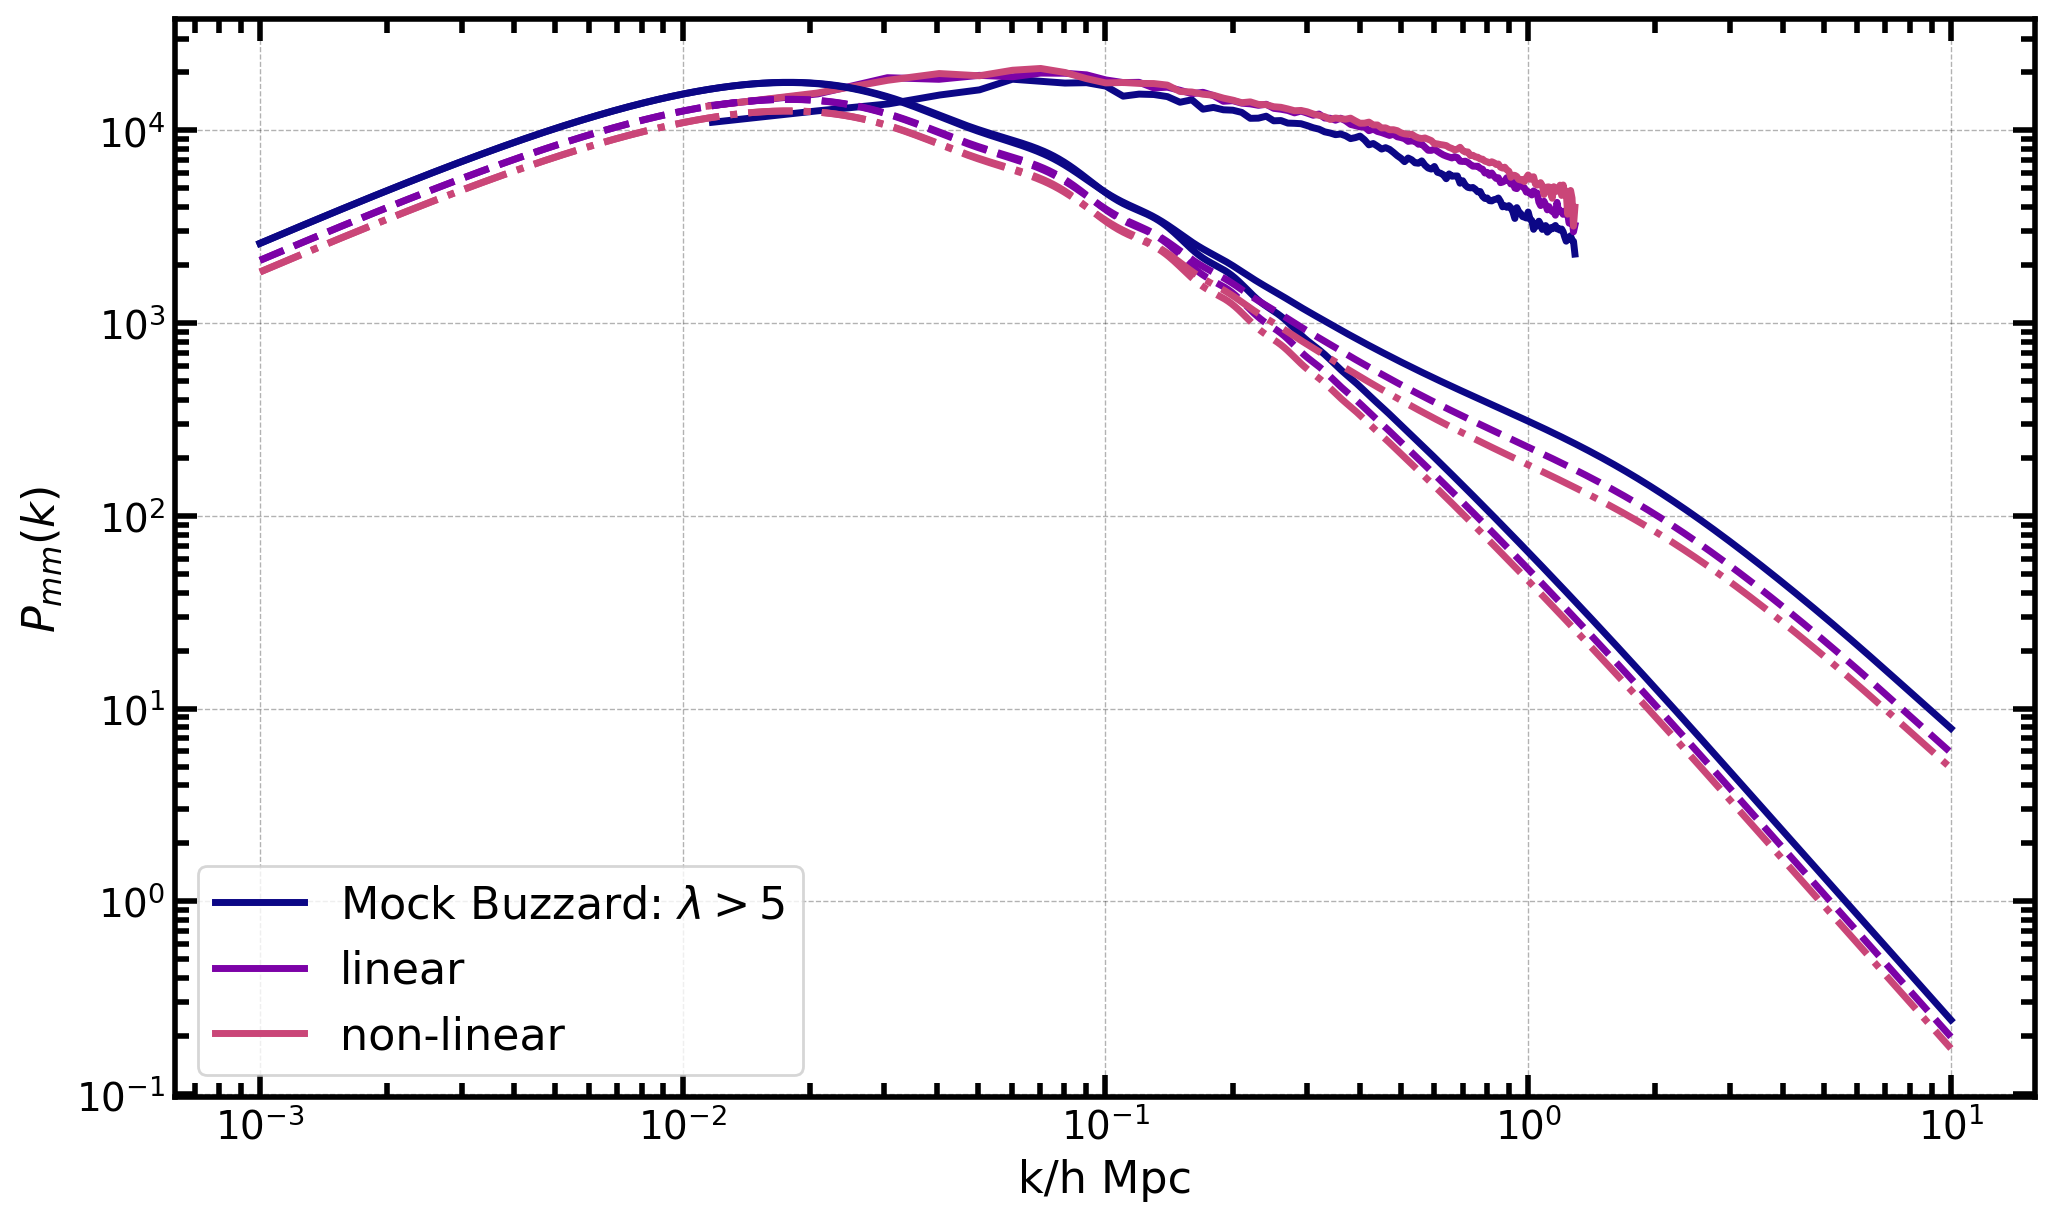

In [342]:
b=1.
for i in range(3):
    k, pk = avg_pks[i]
    plt.loglog(k, pk*k, color=colors[i])
    
for i, (redshift, line) in enumerate(zip(z_lin,['-','--','-.'])):
    plt.loglog(kh_lin, b**2*pk_lin[i,:], color=colors[i], ls = line)
    plt.loglog(kh_nonlin, b**2*pk_nonlin[i,:], color=colors[i], ls = line)

plt.xlabel('k/h Mpc');
plt.ylabel(r'$P_{mm}(k)$')
plt.legend(['Mock Buzzard: $\lambda>5$','linear','non-linear'], loc='lower left');
# plt.title('Matter power at z=%s and z= %s'%tuple(z_lin));
# plt.savefig('pk_mock_lgt5_camb.png', transparent=False, facecolor='w', dpi=150)

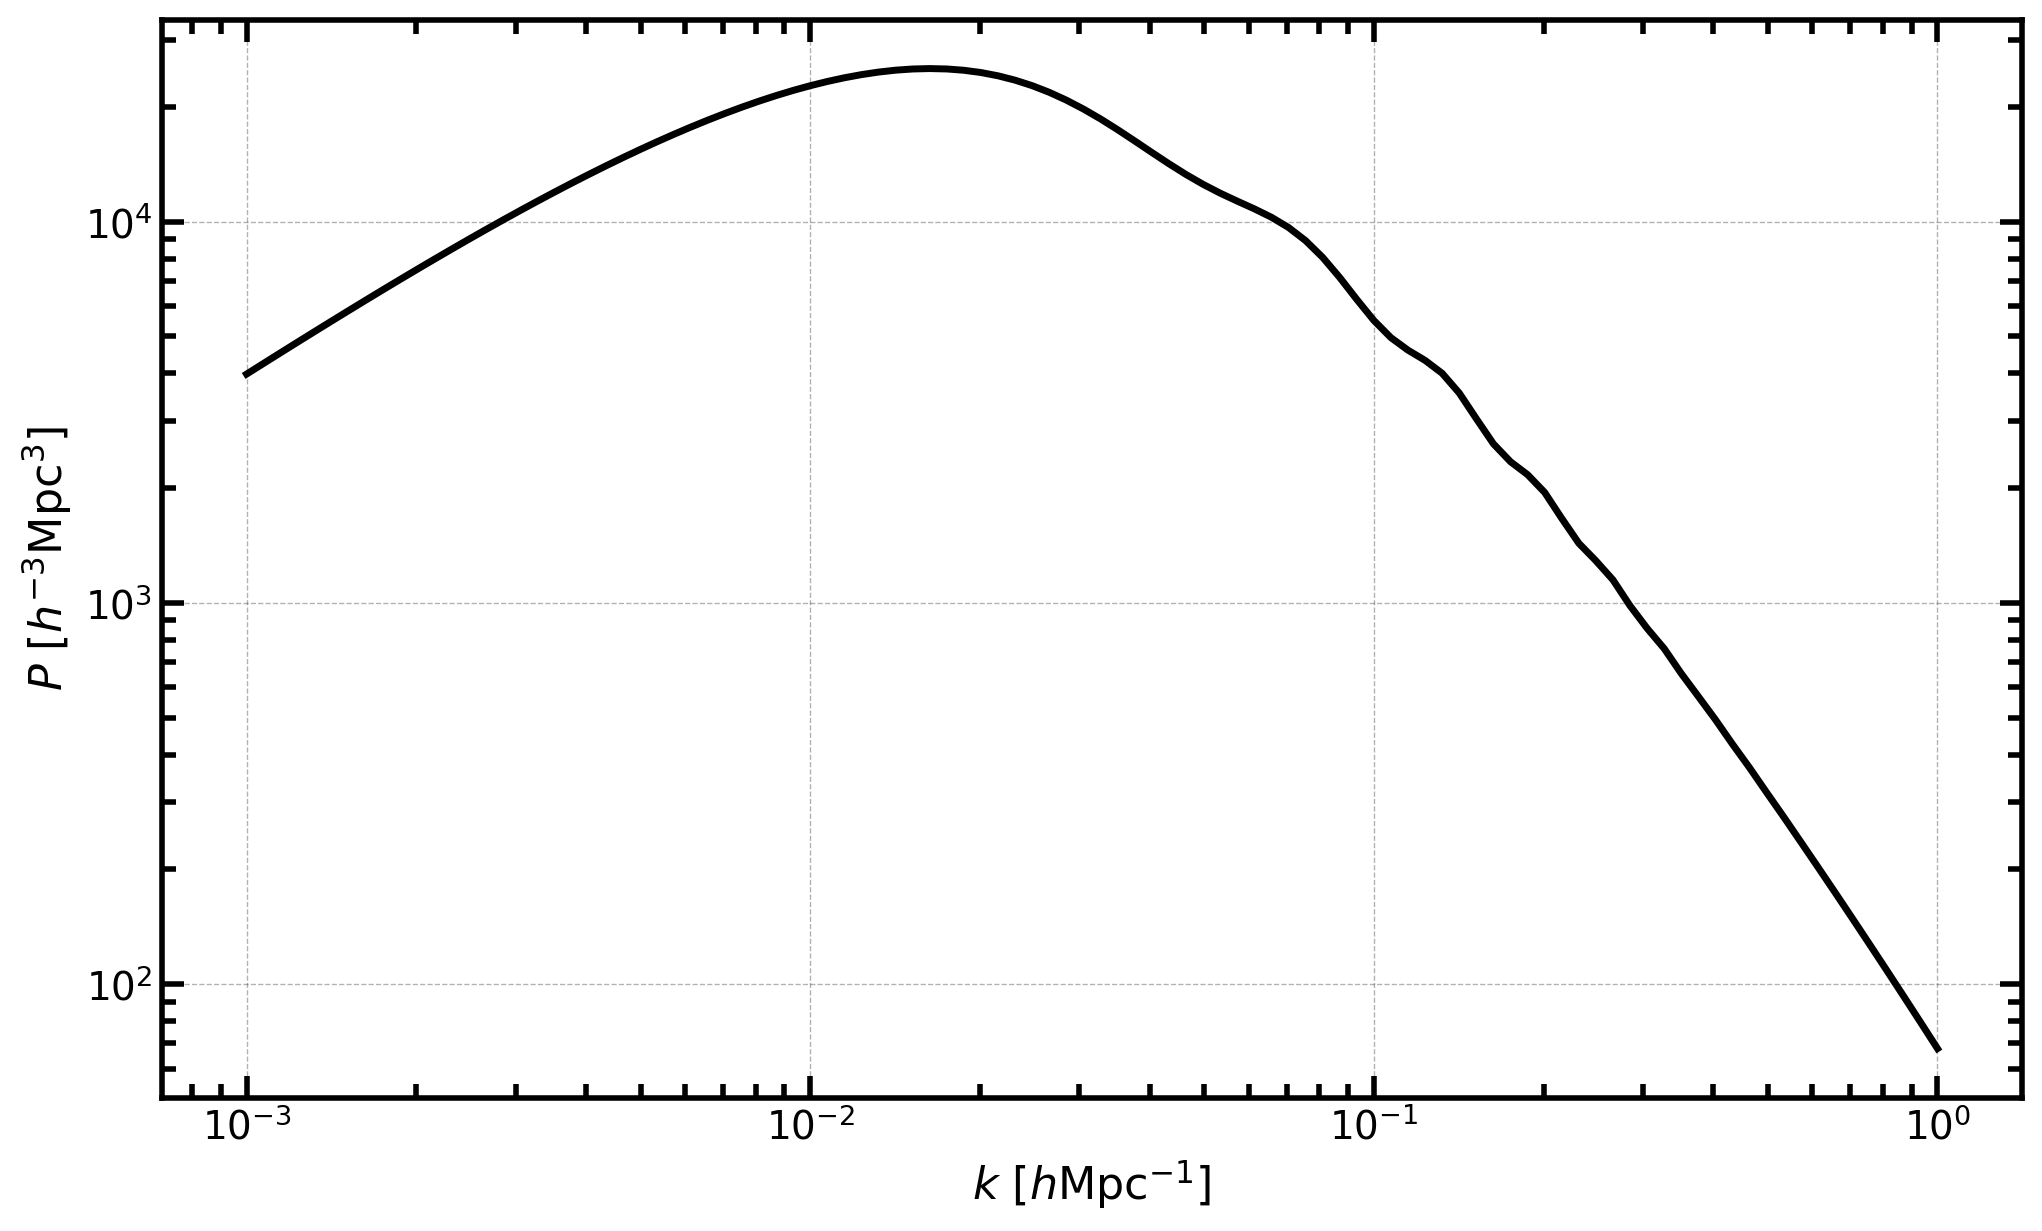

In [343]:
import matplotlib.pyplot as plt
import numpy as np

c = cosmology.Planck15
Plin = cosmology.LinearPower(c, redshift=0., transfer='CLASS')

k = np.logspace(-3, 0, 100)
plt.loglog(k, Plin(k), c='k')

plt.xlabel(r"$k$ $[h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P$ $[h^{-3} \mathrm{Mpc}^{3}]$")
plt.show()

In [344]:
# My randoms don't work

In [345]:
# help(FFTPower)

In [387]:
# result = FFTPower(mesh, mode='2d', Nmu=3, poles=[0,2,4], los=[0,0,1], kmin=0.005, kmax=1.5)


In [324]:
Pkmu = result.poles

In [ ]:
# plot each mu bin
for i in range(Pkmu.shape[1]):
    Pk = Pkmu[:,i] # select the ith mu bin
    label = r'$\mu$=%.1f' % (Pkmu.coords['mu'][i])
    plt.plot(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'], label=label)

# format the axes
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

In [ ]:
#!/usr/bin/env python
from nbodykit.lab import *
from nbodykit import setup_logging, style
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table

setup_logging("debug")

# Cosmology
# fiducial cosmology
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.3)
radii = np.logspace(np.log10(3.), np.log10(200), 100)

# Setup Bin
zbins = np.array([0.2, 0.32, 0.373, 0.51, 0.65])
zmin_list = np.array([0.2, 0.373, 0.51])
zmax_list = np.array([0.32, 0.51, 0.64])
zmeans = np.array([0.25, 0.44, 0.575])


# load file
from fileLoc import FileLocs
from nbodykit import CurrentMPIComm
comm = CurrentMPIComm.get()

if comm.rank == 0:
    floc = FileLocs(machine='nersc')

    print('halo file name: %s'%floc.mock_nbody_fname)
    data = FITSCatalog(floc.mock_nbody_fname)

    print('Random file name: %s'%floc.mock_random_fname)
    randoms = FITSCatalog(floc.mock_random_fname)

    Nr = int(20*data.csize)
    indices = np.random.randint(randoms.csize, size=Nr)
    indices.sort()
    randoms = randoms[indices]

    # add Cartesian position column
    data['Position'] = transform.SkyToCartesian(data['ra'], data['dec'], data['z'], cosmo=cosmo)
    randoms['Position'] = transform.SkyToCartesian(randoms['ra'], randoms['dec'], randoms['z'], cosmo=cosmo)
    
    datas = []
    i = 0
    for zmin, zmax in zip(zmin_list, zmax_list):
        ds = redshift_slice([data, randoms], zmin, zmax)
        ds[0].write('data_%i.fits'%i)
        ds[1].write('rnd_%i.fits'%i)
    
# Slice Catalog
def redshift_slice(jointCat, zmin, zmax):
    datas = []
    for cat in jointCat:
        mask = (cat['z']>=zmin)&(cat['z']<zmax)
        datas.append(cat[mask].copy())
    return datas

if comm.rank != 0:
    i=0
    for i in range(3):
        print('Redshift bin: %i'%i)
        data = FITSCatalog('data_%i.fits'%i)
        rnd = FITSCatalog('rnd_%i.fits'%i)

        print('Power Spectrum')
        print('tbd')

        print('Correlation Function')
        cr = SurveyData2PCF('1d', data, rnd, radii, cosmo=cosmo,  ra='ra', dec='dec', redshift='z', show_progress=True)
        cr.save("2pcf_%i.json"%i)

# srun -n 4 python example.py

In [382]:
def dask_to_table(cat):
    out = Table()
    columns = list(cat.columns)
    for col in columns:
        out[col] = np.array(cat[col])
    return out

In [385]:
datas = []
i = 0
for zmin, zmax in zip(zmin_list, zmax_list):
    ds = redshift_slice([data, randoms], zmin, zmax)
    tb1 = dask_to_table(ds[0])
    tb2 = dask_to_table(ds[1])
    tb1.write(floc.halo_run_loc+'data_%i.fits'%i, overwrite=True)
    tb2.write(floc.halo_run_loc+'rnd_%i.fits'%i, overwrite=True)
    i+=1

In [386]:
# tb1

In [348]:
def redshift_slice(jointCat, zmin, zmax):
    datas = []
    for cat in jointCat:
        mask = (cat['z']>=zmin)&(cat['z']<zmax)
        datas.append(cat[mask].copy())
    return datas